# Control Examples

This page covers two examples from the book, [Multi-parametric Optimization and Control](https://www.wiley.com/en-us/Multi+parametric+Optimization+and+Control-p-9781119265184), to show how it is implimented in PPOPT.

In [98]:
from typing import Union
import numpy as np
from scipy.linalg import solve_discrete_are, block_diag

from ppopt.mpqp_program import MPQP_Program
from ppopt.mp_solvers.solve_mpqp import solve_mpqp, mpqp_algorithm

#### Define functions to help solve mpc problems

In [99]:
def make_LQR_MPC_QP(
        stat_mat: np.ndarray, ctrl_mat: np.ndarray, ricc_wgt: np.ndarray,
        stat_wgt: np.ndarray, ctrl_wgt: np.ndarray, num_step: int,
        all_t_input_cmat: np.ndarray, all_t_input_cvec: np.ndarray,
        initl_state_cmat: np.ndarray, initl_state_cvec: np.ndarray,
        all_t_state_cmat: Union[np.ndarray, None]=None,
        all_t_state_cvec: Union[np.ndarray, None]=None,
        final_state_cmat: Union[np.ndarray, None]=None,
        final_state_cvec: Union[np.ndarray, None]=None) \
    -> np.ndarray:

    if all_t_state_cmat is None or all_t_state_cvec is None:
        all_t_state_cmat = np.empty((0, stat_mat.shape[0]), float)
        all_t_state_cvec = np.empty((0,), float)
    if final_state_cmat is None or final_state_cvec is None:
        final_state_cmat = np.empty((0, stat_mat.shape[0]), float)
        final_state_cvec = np.empty((0,), float)

    Bk = np.zeros((ctrl_mat.shape[0], ctrl_mat.shape[1]*num_step), float)

    num_inpt = all_t_input_cvec.size

    alts_off = 0
    inpt_off = alts_off + all_t_state_cvec.size*num_step
    cnst_off = inpt_off + all_t_input_cvec.size*num_step
    G = np.zeros((cnst_off + final_state_cvec.size, ctrl_mat.shape[1]*num_step), float)
    S = np.zeros((cnst_off + final_state_cvec.size, stat_mat.shape[1]), float)

    Ak = stat_mat
    cycslice = np.r_[-ctrl_mat.shape[1]:(ctrl_mat.shape[1]*num_step + -ctrl_mat.shape[1])]
    Bk[:,cycslice[:ctrl_mat.shape[1]]] = ctrl_mat

    H = Bk[:,cycslice].T@stat_wgt@Bk[:,cycslice]
    Z = Bk[:,cycslice].T@(stat_wgt + stat_wgt.T)@Ak
    M = Ak.T@stat_wgt@Ak

    G[:all_t_state_cvec.size,:] = all_t_state_cmat@Bk[:,cycslice]

    S[:all_t_state_cvec.size,:] = -all_t_state_cmat@Ak

    for indx in range(1, num_step - 1, 1):

        Ak = stat_mat@Ak
        indy = -(indx + 1)
        cycslice = np.r_[indy*ctrl_mat.shape[1]:(indy*ctrl_mat.shape[1] + ctrl_mat.shape[1]*num_step)]
        Bk[:,cycslice[:ctrl_mat.shape[1]]] = stat_mat@Bk[:,cycslice[ctrl_mat.shape[1]:2*ctrl_mat.shape[1]]]

        H += Bk[:,cycslice].T@stat_wgt@Bk[:,cycslice]
        Z += Bk[:,cycslice].T@(stat_wgt + stat_wgt.T)@Ak
        M += Ak.T@stat_wgt@Ak

        G[indx*all_t_state_cvec.size:(indx + 1)*all_t_state_cvec.size,:] \
            = all_t_state_cmat@Bk[:,cycslice]

        S[indx*all_t_state_cvec.size:(indx + 1)*all_t_state_cvec.size,:] \
            = -all_t_state_cmat@Ak

    Ak = stat_mat@Ak
    Bk[:,:ctrl_mat.shape[1]] = stat_mat@Bk[:,ctrl_mat.shape[1]:2*ctrl_mat.shape[1]]

    H += Bk.T@ricc_wgt@Bk
    H += block_diag(*((ctrl_wgt,)*num_step))
    Z += Bk.T@(ricc_wgt + ricc_wgt.T)@Ak
    M += Ak.T@ricc_wgt@Ak

    G[(inpt_off - all_t_state_cvec.size):inpt_off,:] = all_t_state_cmat@Bk
    G[inpt_off:cnst_off,:] = block_diag(*((all_t_input_cmat,)*num_step))
    G[cnst_off:] = final_state_cmat@Bk

    S[(inpt_off - all_t_state_cvec.size):inpt_off,:] = -all_t_state_cmat@Ak
    S[inpt_off:cnst_off,:] = np.zeros((all_t_input_cvec.size*num_step, stat_mat.shape[1]), float)
    S[cnst_off:] = -final_state_cmat@Ak

    W = np.block([np.tile(all_t_state_cvec, (num_step,)),
        np.tile(all_t_input_cvec, (num_step,)), final_state_cvec])[:,np.newaxis]

    return H, Z, M, G, W, S, initl_state_cmat, initl_state_cvec[:,np.newaxis]

## Example 10.4.1

The next cells will set up the example problem solution and discuss the results.

In [100]:
A = np.array([[ 1.0,  1.0], [ 0.0,  1.0]], float)
B = np.array([[ 0.0], [ 1.0]], float)
C = np.array([[ 1.0,  2.0]], float)
D = np.array([[ 0.0]], float)

Q = np.array([[ 1.0,  0.0], [ 0.0,  1.0]], float)
R = np.array([[ 0.01]], float)

x_lbound = np.array([-10.0, -10.0], float)
x_ubound = np.array([ 10.0,  10.0], float)
y_lbound = np.array([-25.0], float)
y_ubound = np.array([ 25.0], float)
u_lbound = np.array([-1.0], float)
u_ubound = np.array([ 1.0], float)

AT = np.array([
    [ 0.6136,  1.6099],
    [-0.3742, -0.3682],
    [-0.6136, -1.6099],
    [ 0.3742,  0.3682]], float)

bT = np.array([1.0, 1.0, 1.0, 1.0], float)

N = 10

Now compute the final time step error weight which makes this problem equivalent to a LQR problem.

In [101]:
P = solve_discrete_are(A, B, Q, R)

Now call the helper function which will take the standard LQR problem and convert it into a MPC problem with N time steps, the desired input, state, and output constraints at all time steps, parameter constraints that match the state and output constraints, and the desired final time step constraints.  The resulting arrays define the quadratic program equivalent to the desired MPC problem.

In [102]:
Hs, Zs, Ms, Gs, Ws, Ss, CRa, CRb = make_LQR_MPC_QP(A, B, P, Q, R, N,
    np.block([[-np.identity(u_lbound.size, float)],
              [ np.identity(u_ubound.size, float)]]),
    np.block([-u_lbound,  u_ubound]),
    np.block([[-np.identity(x_lbound.size, float)],
              [ np.identity(x_ubound.size, float)], [-C], [ C]]),
    np.block([-x_lbound,  x_ubound, -y_lbound,  y_ubound]),
    np.block([[-np.identity(x_lbound.size, float)],
              [ np.identity(x_ubound.size, float)], [-C], [ C]]),
    np.block([-x_lbound,  x_ubound, -y_lbound,  y_ubound]),
    AT, bT)

Convert the MPC quadratic program into a PPOPT mpQP object, process its constraints, execute the solution process, and save the result.

In [103]:
prog = MPQP_Program(Gs, Ws, np.zeros((B.shape[1]*N,1), float), Zs, 2.0*Hs, CRa, CRb, Ss)

prog.process_constraints()

solution_example_1 = solve_mpqp(prog, mpqp_algorithm.graph)

First region ()


We can now plot the parametric solution. As there are only 2 parameters, we can plot this with the ``parametric_plot`` function.

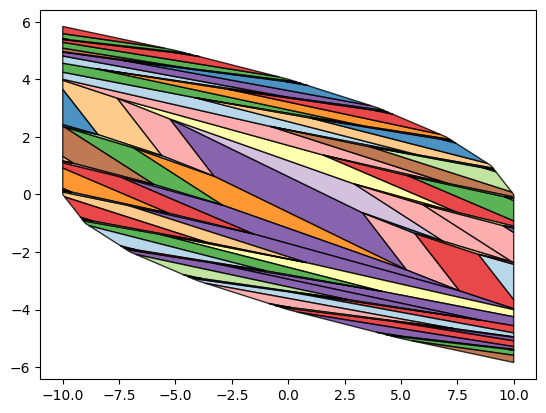

In [104]:
from ppopt.plot import parametric_plot

parametric_plot(solution_example_1)

## Example 11.2.1

The next cells will execute the example problem solution and discuss the results.  First, set up the LQR problem statement.  The final time step error weight is the solution to the Riccati equation using the undisturbed system dynamics:

In [105]:
A = np.array([[ 1.0,  1.0], [ 0.0,  1.0]], float)
B = np.array([[ 0.0], [ 1.0]], float)

Q = np.array([[ 1.0,  0.0], [ 0.0,  1.0]], float)
R = np.array([[ 0.01]], float)

P = solve_discrete_are(A, B, Q, R)

Now set up the constraints as before, but note the new final state constraints.  Also set the number of steps.

In [106]:
x_lbound = np.array([-10.0, -10.0], float)
x_ubound = np.array([ 10.0,  10.0], float)
y_lbound = np.array([-25.0], float)
y_ubound = np.array([ 25.0], float)
u_lbound = np.array([-1.0], float)
u_ubound = np.array([ 1.0], float)

AT = np.array([
    [ 0.3358,  0.8809, -0.3336],
    [-0.2553, -0.2512,  0.9336],
    [-0.0001, -0.0001,  1.0000],
    [ 0.0001,  0.0001, -1.0000],
    [ 0.2553,  0.2512, -0.9336],
    [-0.3358, -0.8809,  0.3336]], float)
bT = np.array([ 0.5472, 0.6823, 0.6961, 0.6961, 0.6823, 0.5472], float)

N = 10

Now define the disturbance parameters.  B_tilde is the disturbance gain matrix; the component of the next state due to the disturbance.

One might naively suppose that one should handle disturbance bounds as with state bounds because they are now part of the state.  This is incorrect.  Constraints processing cannot handle trivial constraints with an all-zeros vector; the disturbance constraints would add these if we included the disturbance constraints with the state constraints because we will zero the disturbance row of the A matrix.

Note that the influence of the disturbance on the system is fully accounted-for through its inclusion in matrix A; not including disturbance constraints would not alter the modeled impact of the disturbance.
Note that the disturbance is, in fact, just part of the parameter vector for the optimization process; disturbance constraints should be involved in the parameter constraints only.

In [107]:
B_tilde = np.array([[-1.0], [ 1.0]], float)

d_lbound = np.array([-0.5], float)
d_ubound = np.array([ 0.5], float)

The state vector has the disturbance appended to it, so we must add the  linear relationship of the disturbance to the state update as a column in A.  The disturbance is an exogeneous state so the dynamics cannot update it, hence the row of the equation of motion corresponding to the disturbance is all zeros except for the disturbance column.  This column carries the disturbance through every time step (because it is constant).

The input does not directly affect the disturbance, so the disturbance row of B is zero.

The disturbance does not directly impact the output, so append a zero column to C.

In [108]:
A = np.block([[A, B_tilde], [np.array([0.0, 0.0, 1.0], float)]])
B = np.block([[B], [np.zeros((1, 1), float)]])
C = np.block([[C, np.zeros((1, 1), float)]])

The state was augmented, so Q and P must also be augmented so that we can create the quadratic program; assign zero weight to the disturbance because it is a parameter only (the objective function term that includes it cannot be affected by the decision variables and therefore can only offset the objective value) and cannot alter the optimum via the objective function (its effect is only felt through the constraints)

Note that the optimizer must now alter the decision variables directly to counter-act the effect of the constant disturbance in the equation of motion; the decision variables become functions of the disturbance to optimize the objective in the presence of the disturbance (like a feed-forward path if the setpoint were to be viewed as a disturbance)

In [109]:
Q = np.block([[Q, np.zeros((2, 1), float)], [np.zeros((1, 3), float)]])
P = np.block([[P, np.zeros((2, 1), float)], [np.zeros((1, 3), float)]])

Now call the helper function which will take the standard LQR problem and convert it into a MPC problem with N time steps, the desired input, state, and output constraints at all time steps, parameter constraints that match the state and output constraints, and the desired final time step constraints.  The resulting arrays define the quadratic program equivalent to the desired MPC problem.

Unlike last time, we must now add some rows in the parameter constraints to enable us to bound the disturbance as desired.  We are also adjusting some other constraint matrices to account for the added state.  Remember that the disturbance bounds were not appended to the state bounds because this would create trivial constraints that PPOPT cannot handle.

In [110]:
I_Ax = np.identity(A.shape[0], float)[:2,:]

Hs, Zs, Ms, Gs, Ws, Ss, CRa, CRb = make_LQR_MPC_QP(A, B, P, Q, R, N,
    np.block([
        [-np.identity(u_lbound.size, float)], [ np.identity(u_ubound.size, float)]]),
    np.block([-u_lbound,  u_ubound]),
    np.block([[-I_Ax], [ I_Ax], [-C], [ C],
        [np.array([[  0.0,  0.0, -1.0]])], [np.array([[  0.0,  0.0,  1.0]])]]),
    np.block([-x_lbound,  x_ubound, -y_lbound,  y_ubound, -d_lbound,  d_ubound]),
    np.block([[-I_Ax], [ I_Ax], [-C], [ C]]),
    np.block([-x_lbound,  x_ubound, -y_lbound,  y_ubound]),
    AT, bT)

Convert the MPC quadratic program into a PPOPT mpQP object, process its constraints, execute the solution process, and save the result.

In [111]:
prog = MPQP_Program(Gs, Ws, np.zeros((B.shape[1]*N, 1), float), Zs, 2.0*Hs, CRa, CRb, Ss)

prog.process_constraints()

solution_example_2 = solve_mpqp(prog, mpqp_algorithm.graph)

First region ()


Now that we have the mpMPC with and without the measured disturbance, we can compare the explicit solution between the two.

In [116]:
solution_example_2.critical_regions[0].A[:,:2] - solution_example_1.critical_regions[0].A

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

## Conclusions

The non-disturbance portion of the solution exactly matches the previous example; this seems why the authors of the book decided not to include an appendix for it.  There is a critical region in my solution that exactly matches the one in Table 11.2, so this disturbance rejection code is verified to the extent possible.